# Diamonds

##  Predicting is the price of a diamond.
Run OLS regressions, fit a Lasso model, and create a random forest for diamond dataset

Load the required packages and diamond dataset

In [45]:
# Load required packages
library(ggplot2)
library(dplyr)
library(glmnet)
library(stats)
library(repr)
library(rpart) # For tree functions
library(randomForest) # For Random Forest

# Load the dataset
Diamonds <- read.csv("Diamonds_sample.csv", header = TRUE, stringsAsFactors = TRUE)
Diamonds <- na.omit(Diamonds) # Remove rows with NA values

Print the first few lines of the data and calculate the average cost of a diamond.

In [46]:
head(Diamonds)
summary(Diamonds) 
#The average cost (mean) is $3266

ï..GEM_ID,carat,clarity,high_color,cut,cost
47129,0.2746253,1,1,1,3468.159
26282,0.4699232,1,1,1,4814.552
25473,0.6673995,1,1,1,6473.046
15093,0.4628467,1,1,1,2992.616
83048,0.5830976,1,0,1,5471.689
22707,0.4277917,1,1,1,3999.953


   ï..GEM_ID         carat            clarity         high_color    
 Min.   :  235   Min.   :0.03988   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:26178   1st Qu.:0.25546   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :48003   Median :0.36372   Median :1.0000   Median :1.0000  
 Mean   :49804   Mean   :0.37141   Mean   :0.7366   Mean   :0.6188  
 3rd Qu.:73998   3rd Qu.:0.48627   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :99651   Max.   :0.88796   Max.   :1.0000   Max.   :1.0000  
      cut              cost      
 Min.   :0.0000   Min.   :-1473  
 1st Qu.:0.0000   1st Qu.: 2184  
 Median :1.0000   Median : 3229  
 Mean   :0.7109   Mean   : 3266  
 3rd Qu.:1.0000   3rd Qu.: 4295  
 Max.   :1.0000   Max.   : 8556  

Prep data to run lasso. Glmnet package requires data as matrices.

Remove unnecessary GEM_ID variable from dataset. Create a new dataset that contains all the other variables.

Outcome defined as ``cost``

In [47]:
newvars <- c("carat","clarity", "high_color", "cut", "cost")
dataSet <- Diamonds[newvars]
head(dataSet)
summary(dataSet)
x <- model.matrix(cost~., dataSet)[,-1]
head(x)
y <- dataSet$cost

carat,clarity,high_color,cut,cost
0.2746253,1,1,1,3468.159
0.4699232,1,1,1,4814.552
0.6673995,1,1,1,6473.046
0.4628467,1,1,1,2992.616
0.5830976,1,0,1,5471.689
0.4277917,1,1,1,3999.953


     carat            clarity         high_color          cut        
 Min.   :0.03988   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.25546   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.36372   Median :1.0000   Median :1.0000   Median :1.0000  
 Mean   :0.37141   Mean   :0.7366   Mean   :0.6188   Mean   :0.7109  
 3rd Qu.:0.48627   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :0.88796   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
      cost      
 Min.   :-1473  
 1st Qu.: 2184  
 Median : 3229  
 Mean   : 3266  
 3rd Qu.: 4295  
 Max.   : 8556  

carat,clarity,high_color,cut
0.2746253,1,1,1
0.4699232,1,1,1
0.6673995,1,1,1
0.4628467,1,1,1
0.5830976,1,0,1
0.4277917,1,1,1


# Divide the data into training and testing data.

Data split evenly into train and test datasets. Seed set and ``sample()`` used to select which observations go into the training dataset.

In [48]:
set.seed(555) # Set seed for reproducibility
# Create a training set and a test set
train_row <- sample(1:nrow(x),nrow(x)/2) #half of the rows make the training set
y_train <- y[train_row] 
x_train <- x[train_row,] 
print("training Y data")
head(y_train)
print("training X data")
head(x_train)

# Assign leftover to test sample
y_test <- y[-train_row] 
x_test <- x[-train_row,]
print("test Y data")
head(y_test)
print("test X data")
head(x_test)

[1] "training Y data"


[1] 3964.8022 6343.2988  597.0237 6045.4663 2631.7300 3624.8750

[1] "training X data"


,carat,clarity,high_color,cut
234,0.5257404,1,0,1
344,0.6961828,1,1,1
400,0.3623806,0,0,0
349,0.6948458,0,0,1
369,0.4214361,0,1,1
117,0.4194272,1,0,0


[1] "test Y data"


[1] 3468.159 5471.689 3017.378 3350.736 4035.406 3107.023

[1] "test X data"


,carat,clarity,high_color,cut
1,0.2746253,1,1,1
5,0.5830976,1,0,1
8,0.2618203,1,1,1
10,0.5300826,1,0,1
13,0.4064561,1,1,1
15,0.3289343,1,1,1


## Lasso

Lasso model created using ``glmnet()`` and plotted

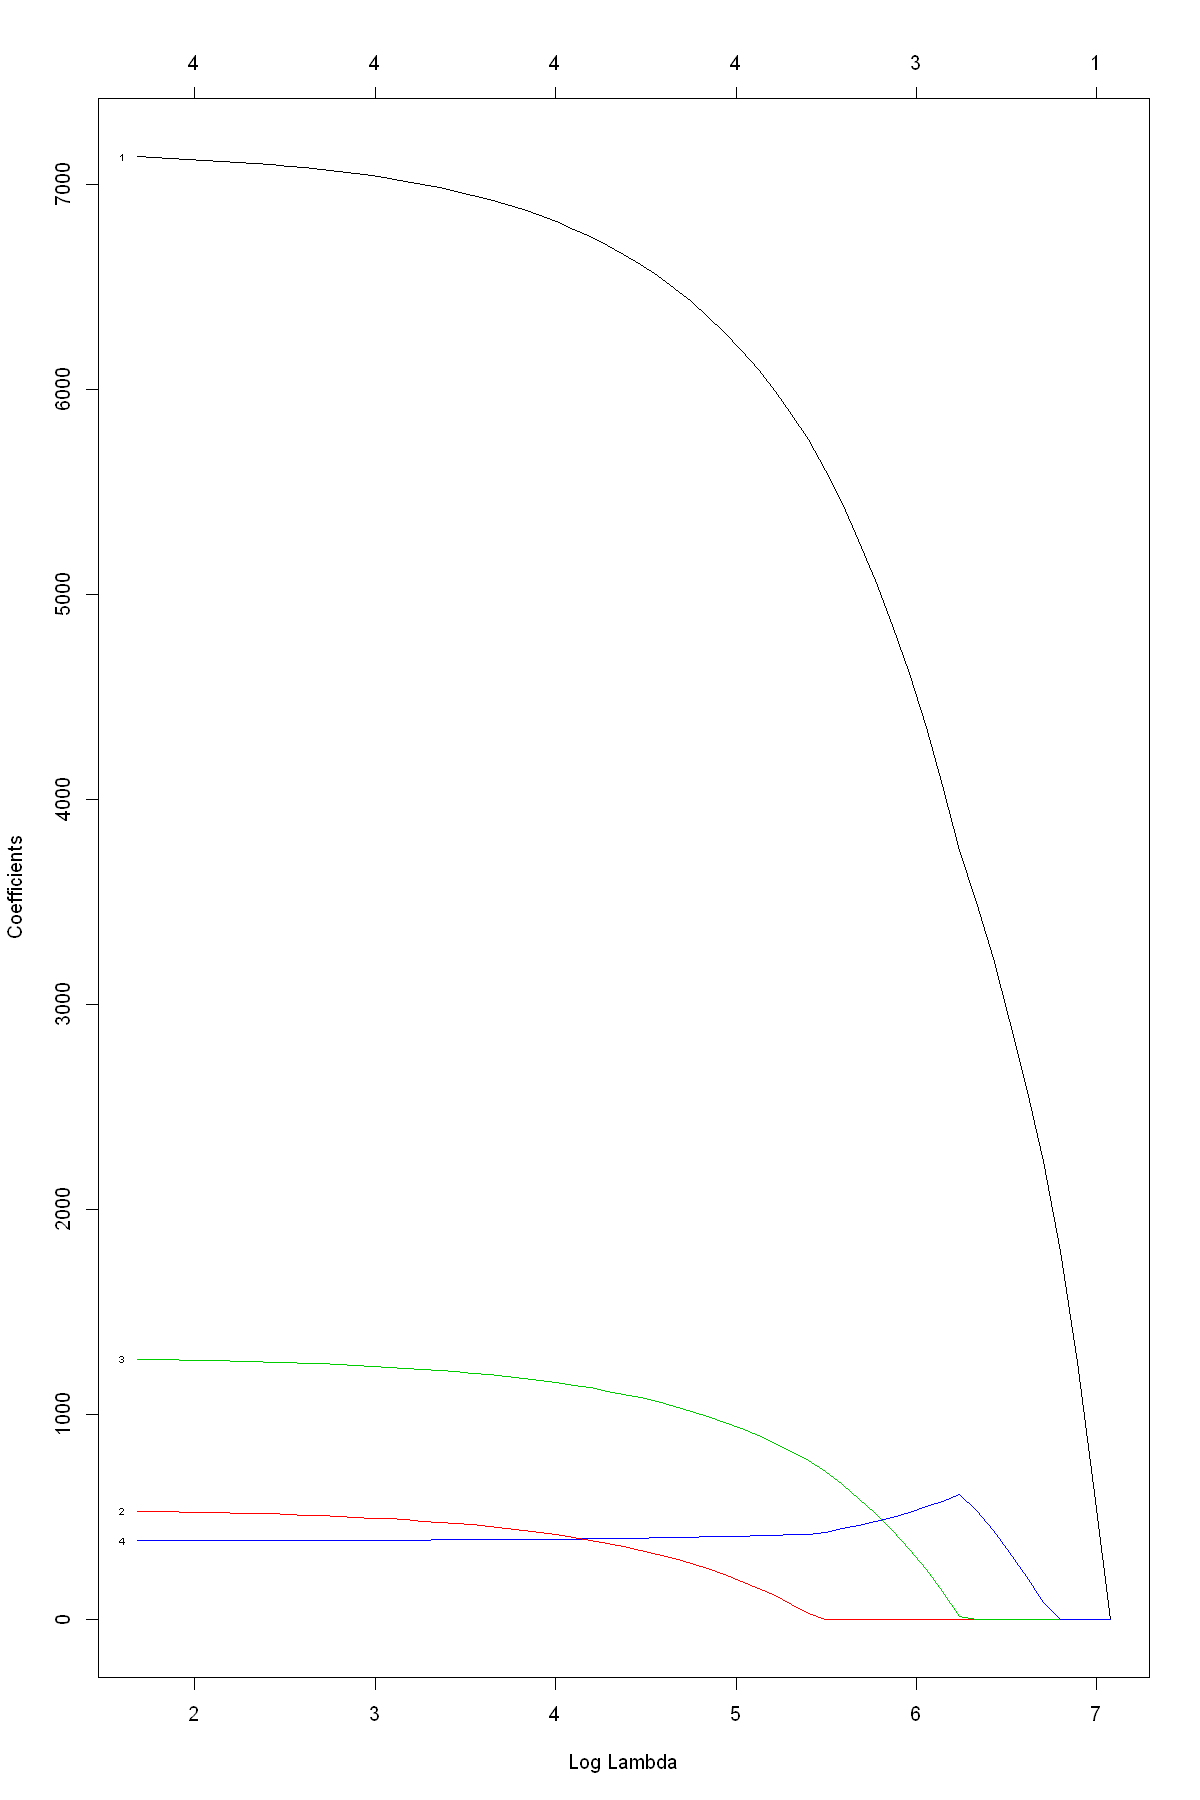

In [49]:
#Fit to full dataset with chosen lambda, examine coefficients
lasso_train <- glmnet(x_train, y_train, alpha=1) #alpha = 1 means lasso.

#Examine coefficients as lambda increases
plot(lasso_train, xvar = "lambda", label = TRUE) 
#graph shows the coefficient for any given lambda. The larger lambda is, the smaller each coefficient gets.

Optimal lambda for a Lasso model selected using cross-validation (``cv.glmnet()``), based on the the lambda that produce the best $R^2$. Using ``nfolds=10`` (the default). Print the optimal lambda. 

[1] "First graph is Log Lambda. Second is Lambda"


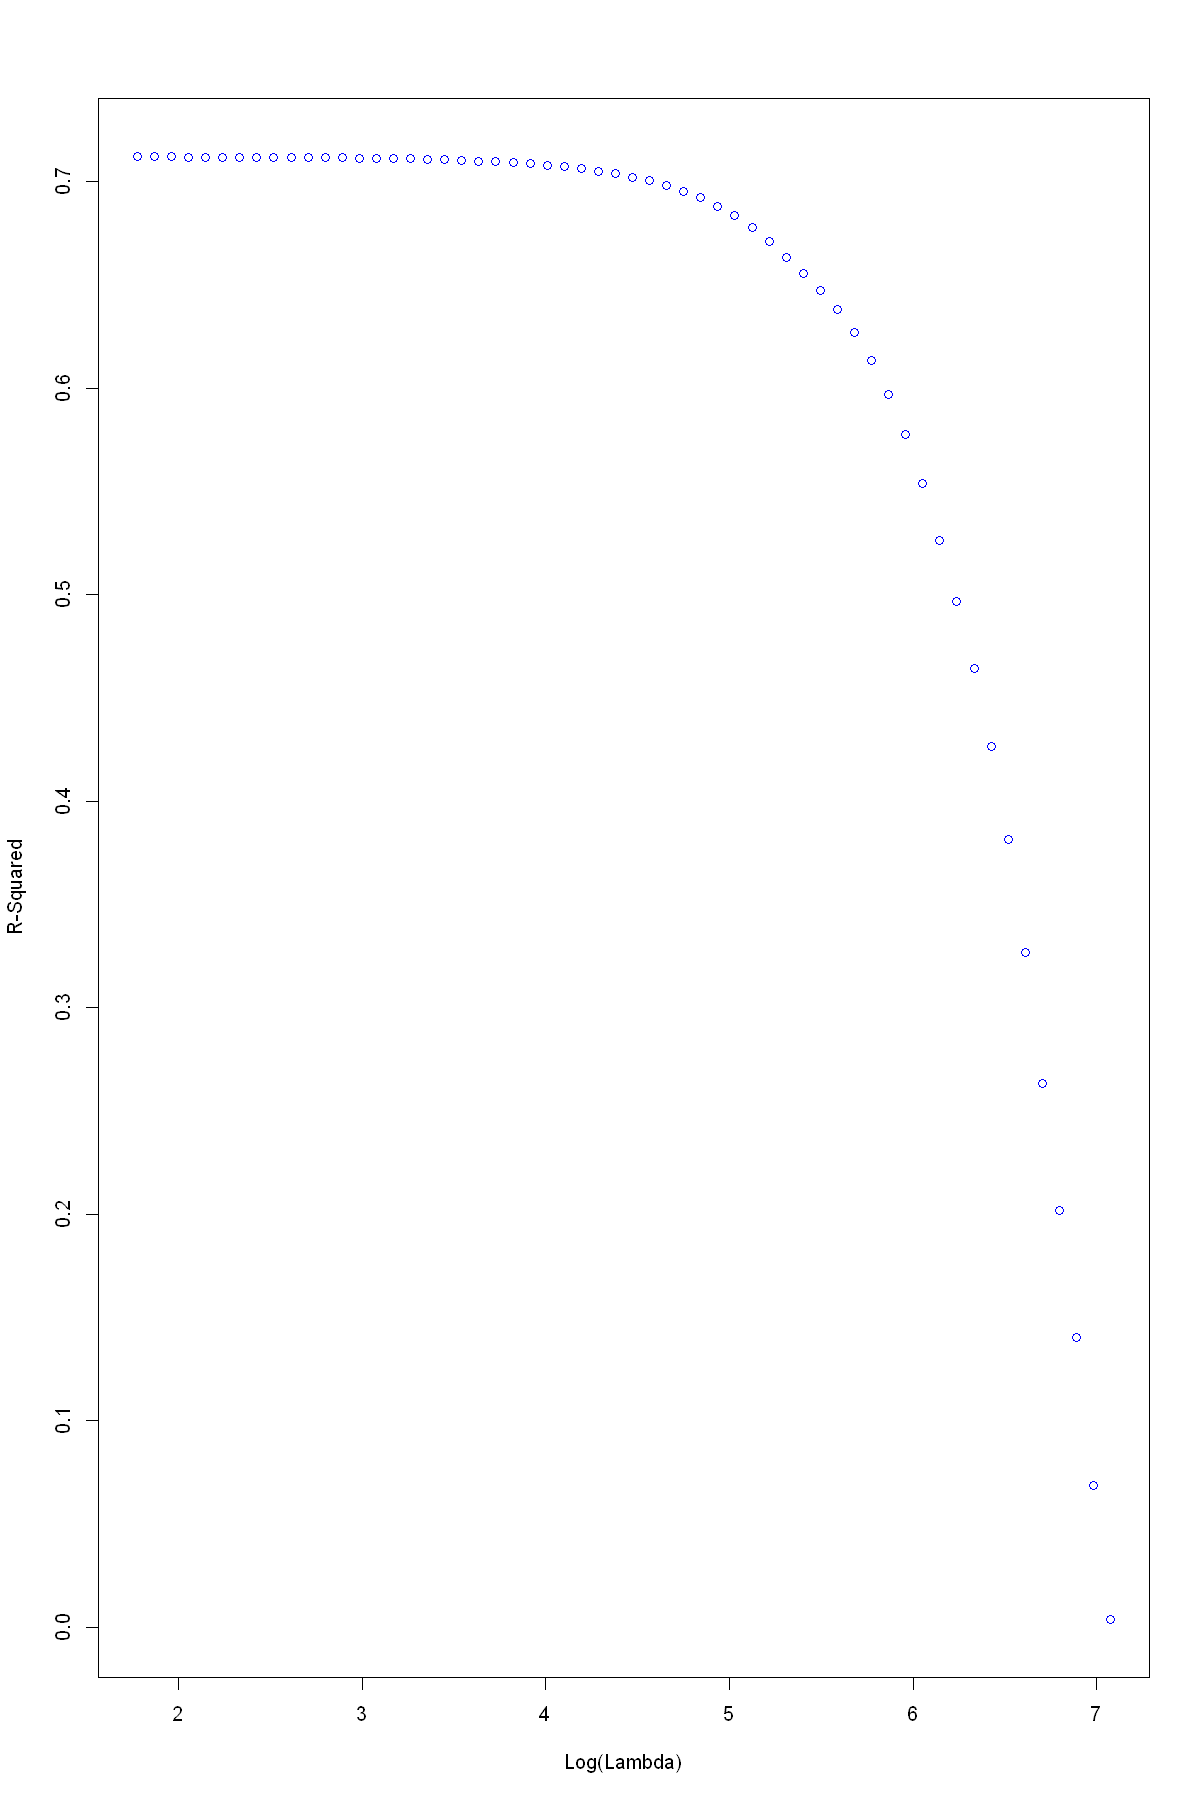

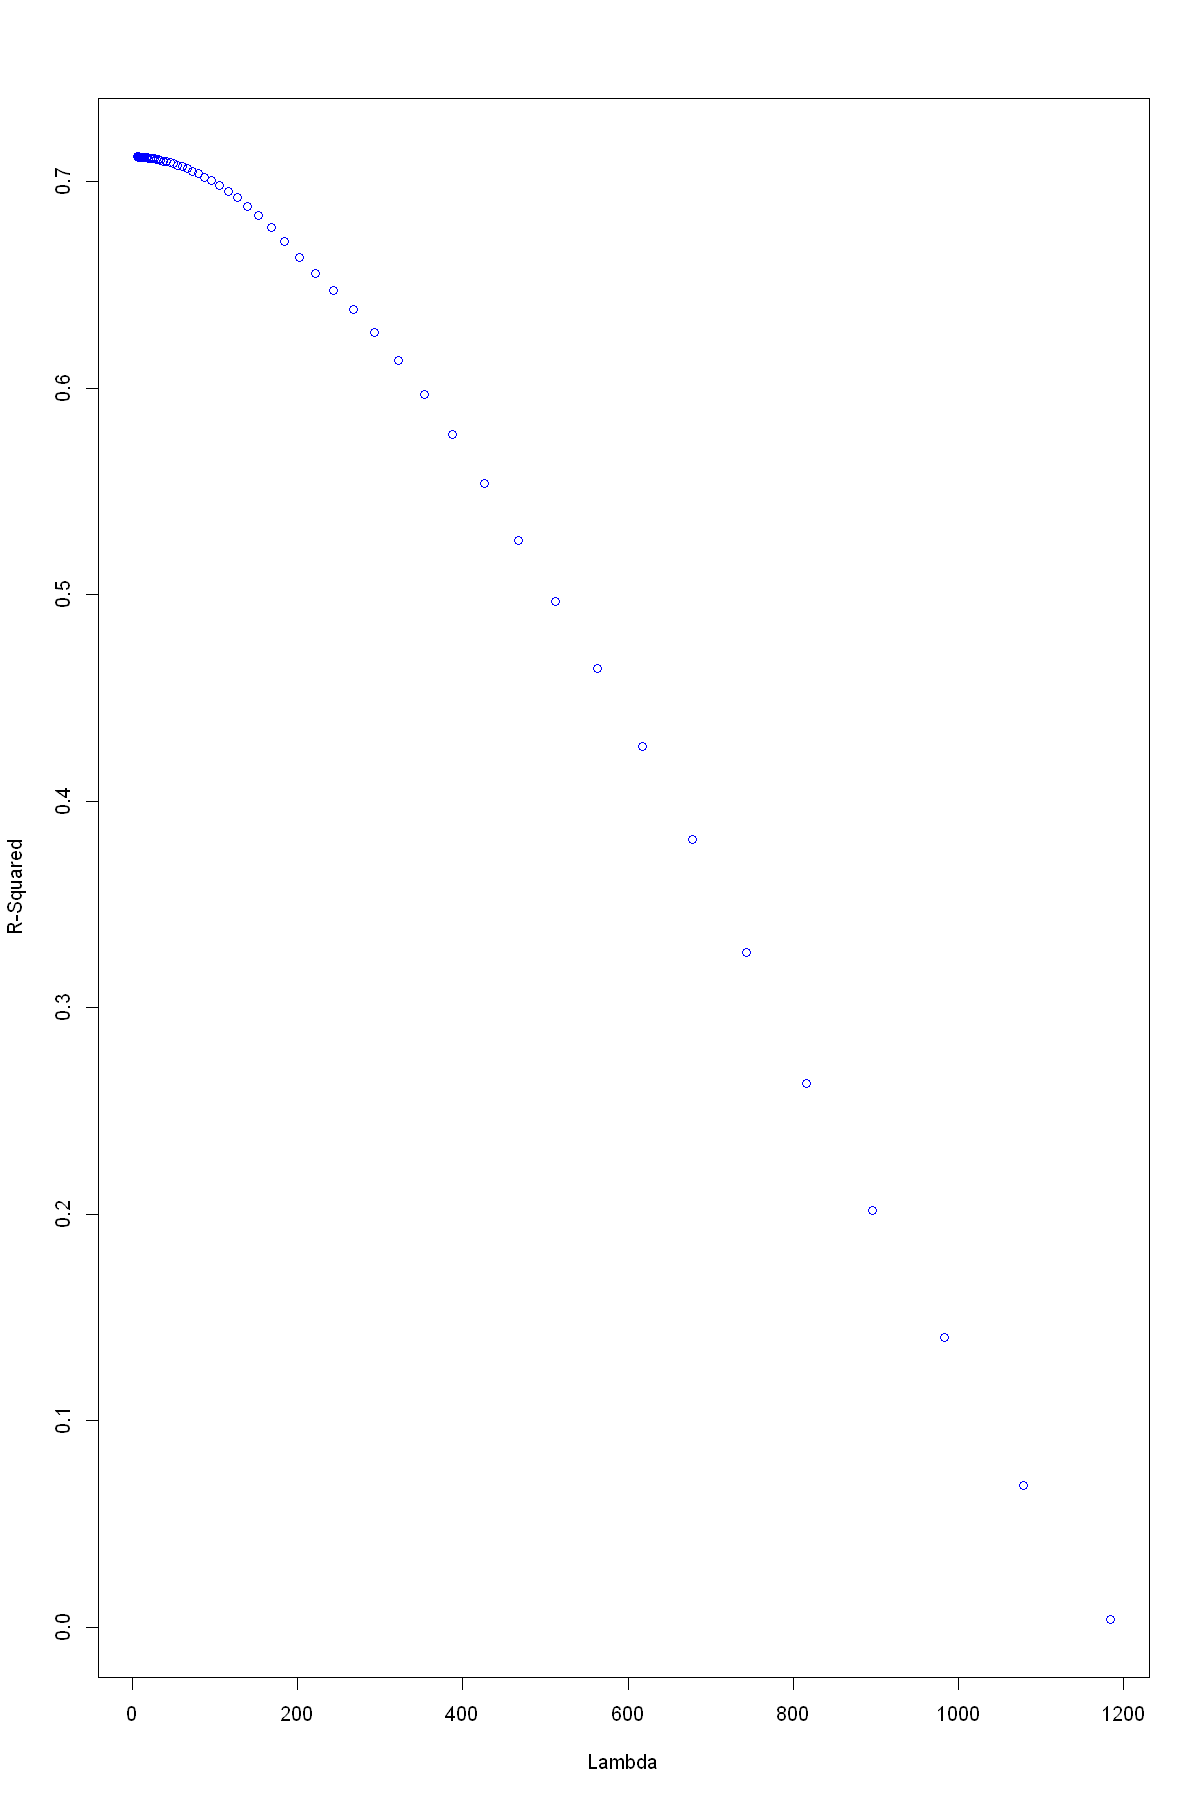

In [50]:
#Set seed for replication
set.seed(555)

#Function to calculate cross-validation errors for all lambda
cv_lasso <- cv.glmnet(x_train, y_train, alpha=1, nfolds=10)

# Calculate the r-squared of the model for each lambda 
r2 <- 1 - cv_lasso$cvm/var(y_train) 

# Plots log(lambda) and R2
print("First graph is Log Lambda. Second is Lambda")
plot(log(cv_lasso$lambda), r2, xlab="Log(Lambda)", ylab="R-Squared", col="Blue")
plot(cv_lasso$lambda, r2, xlab="Lambda", ylab="R-Squared", col="Blue")

Show coefficients of the Lasso model with the optimal lambda

In [51]:
print("max R^2")
max(r2)
print("best Lambda")
best_lambda <- cv_lasso$lambda[which(r2==max(r2))] #stores the optimal lamda
best_lambda
print("log of best lambda")
log(best_lambda)

coef(cv_lasso, s = best_lambda, exact = TRUE, x = x_train, y = y_train)
#x_train is matrix of covariates used to estimate the model, y_train is vector of outcome variable used in the estimation

[1] "max R^2"


[1] 0.7121503

[1] "best Lambda"


[1] 5.892723

[1] "log of best lambda"


[1] 1.773718

5 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) -893.5779
carat       7131.3271
clarity      525.3367
high_color  1266.3479
cut          381.9392

Calculate the Lasso in-sample prediction performance indicator $R^2$ using the optimal lambda. To do this, you have to generate a prediction of the outcome variable using the Lasso model and the training dataset.

In [52]:
# Run lasso with selected lambda on train and test set, get r-square for both
lasso_predict_in <- predict(lasso_train, s=best_lambda, newx = x_train)
lasso_predict_out <- predict(lasso_train, s=best_lambda, newx = x_test)

# Calculate r-square for lasso
print('Lasso In-sample R-squared')
1-mean((lasso_predict_in-y_train)^2)/var(y_train) 

[1] "Lasso In-sample R-squared"


[1] 0.7296913

Calculate the Lasso out-of-sample prediction performance indicator $R^2$. To do this, you have to generate a prediction of the outcome variable using the Lasso model and the test dataset.

In [53]:
print('Lasso Out-of-sample R-squared')
1-mean((lasso_predict_out-y_test)^2)/var(y_test)

[1] "Lasso Out-of-sample R-squared"


[1] 0.7044589

## OLS 
Lasso models belong to the family of linear models. Ordinary Least Squares (OLS), is the best linear unbiased estimator (BLUE), the coefficients from running OLS are an unbiased estimate of the true linear relationship. Lasso differ from OLS by introducing bias into the estimates but reducing variance in the estimates to overall offer better prediction accuracy.  

Estimates an OLS regression on the training dataset (same predictors and outcome). Sets lambda to 0 (``lambda=0``) instead of the optimal lambda. 

In [54]:
#Run OLS with selected lambda on test set, get r-squared for both
ols_train <- glmnet(x_train, y_train, alpha=1, lambda=0)
ols_predict_in <- predict(ols_train, s=0, newx = x_train)
ols_predict_out <- predict(ols_train, s=0, newx = x_test)

Calculate the OLS in-sample prediction performance indicator $R^2$. Generate a prediction of the outcome variable using the OLS model and the training dataset.

In [55]:
# Calculate r-square for OLS
print('OLS In-sample R-squared')
1-mean((ols_predict_in-y_train)^2)/var(y_train) 

[1] "OLS In-sample R-squared"


[1] 0.7297304

Calculate OLS out-of-sample prediction performance indicator $R^2$. Generate a prediction of the outcome variable using the Lasso model and the test dataset.

In [56]:
print('OLS Out-of-sample R-squared')
1-mean((ols_predict_out-y_test)^2)/var(y_test) 
ols <- predict(cv_lasso, type="coefficients", s=0, exact=T, x=x, y=y)
ols

[1] "OLS Out-of-sample R-squared"


[1] 0.7031702

5 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) -667.4681
carat       7115.6819
clarity      465.1563
high_color  1150.0105
cut          332.4517

### In Sample

The Lasso model has an in-sample R2 of 0.729697943. The OLS model has an in-sample R2 of 0.729730408. The OLS model is just slightly better in-sample because of a marginally larger R2

### Out of Sample

The Lasso model has an out-of sample R2 of 0.7044. The OLS model has an out-of sample R2 of 0.7032. The Lasso model is slightly better out of sample because of a larger R2

# Tree to Random Forest

In [57]:
# Set a seed for reproducibility
set.seed(1)

# Create train and test sets (50% for training, 50% for testing)
train_rows <- sample(1:nrow(dataSet), nrow(dataSet)/2)
train <- dataSet[train_rows,]
test <- dataSet[-train_rows,]

head(train)

,carat,clarity,high_color,cut,cost
324,0.4242365,1,1,1,3856.202
167,0.4486376,1,0,0,3375.712
129,0.2878616,1,1,1,2731.184
418,0.4448540,0,0,0,2408.939
299,0.2560836,1,1,1,2080.617
270,0.5616781,1,0,1,4460.562


## Fully Grown Tree

Simple classification tree using the training data to predict whether the diamond is a high value color or not (``high_color``). Tree initially grown without any pruning or depth parameters: set `` cp=0, minsplit=2, minbucket=1``. Display the confusion matrix and calculate the mean squared error in the testing data. 

In [58]:
# Simple classification tree training data using all of the variables
full_tree <- rpart(as.factor(high_color)~., train, method="class", control=rpart.control(cp=0, minsplit=2, minbucket=1))

# Fit model to test data
pred <- predict(full_tree, test, type="class")
test$pred <- ifelse(pred==1, 1, 0)

# Calculate MSE, which is just % incorrect predictions
mean((test$pred-test$high_color)^2)

# Display the "confusion" table where we have the predicted values vs. actual values
confusion <- table(test$pred, test$high_color)
confusion

[1] 0.0982906

   
      0   1
  0  73  11
  1  12 138

Plot the tree

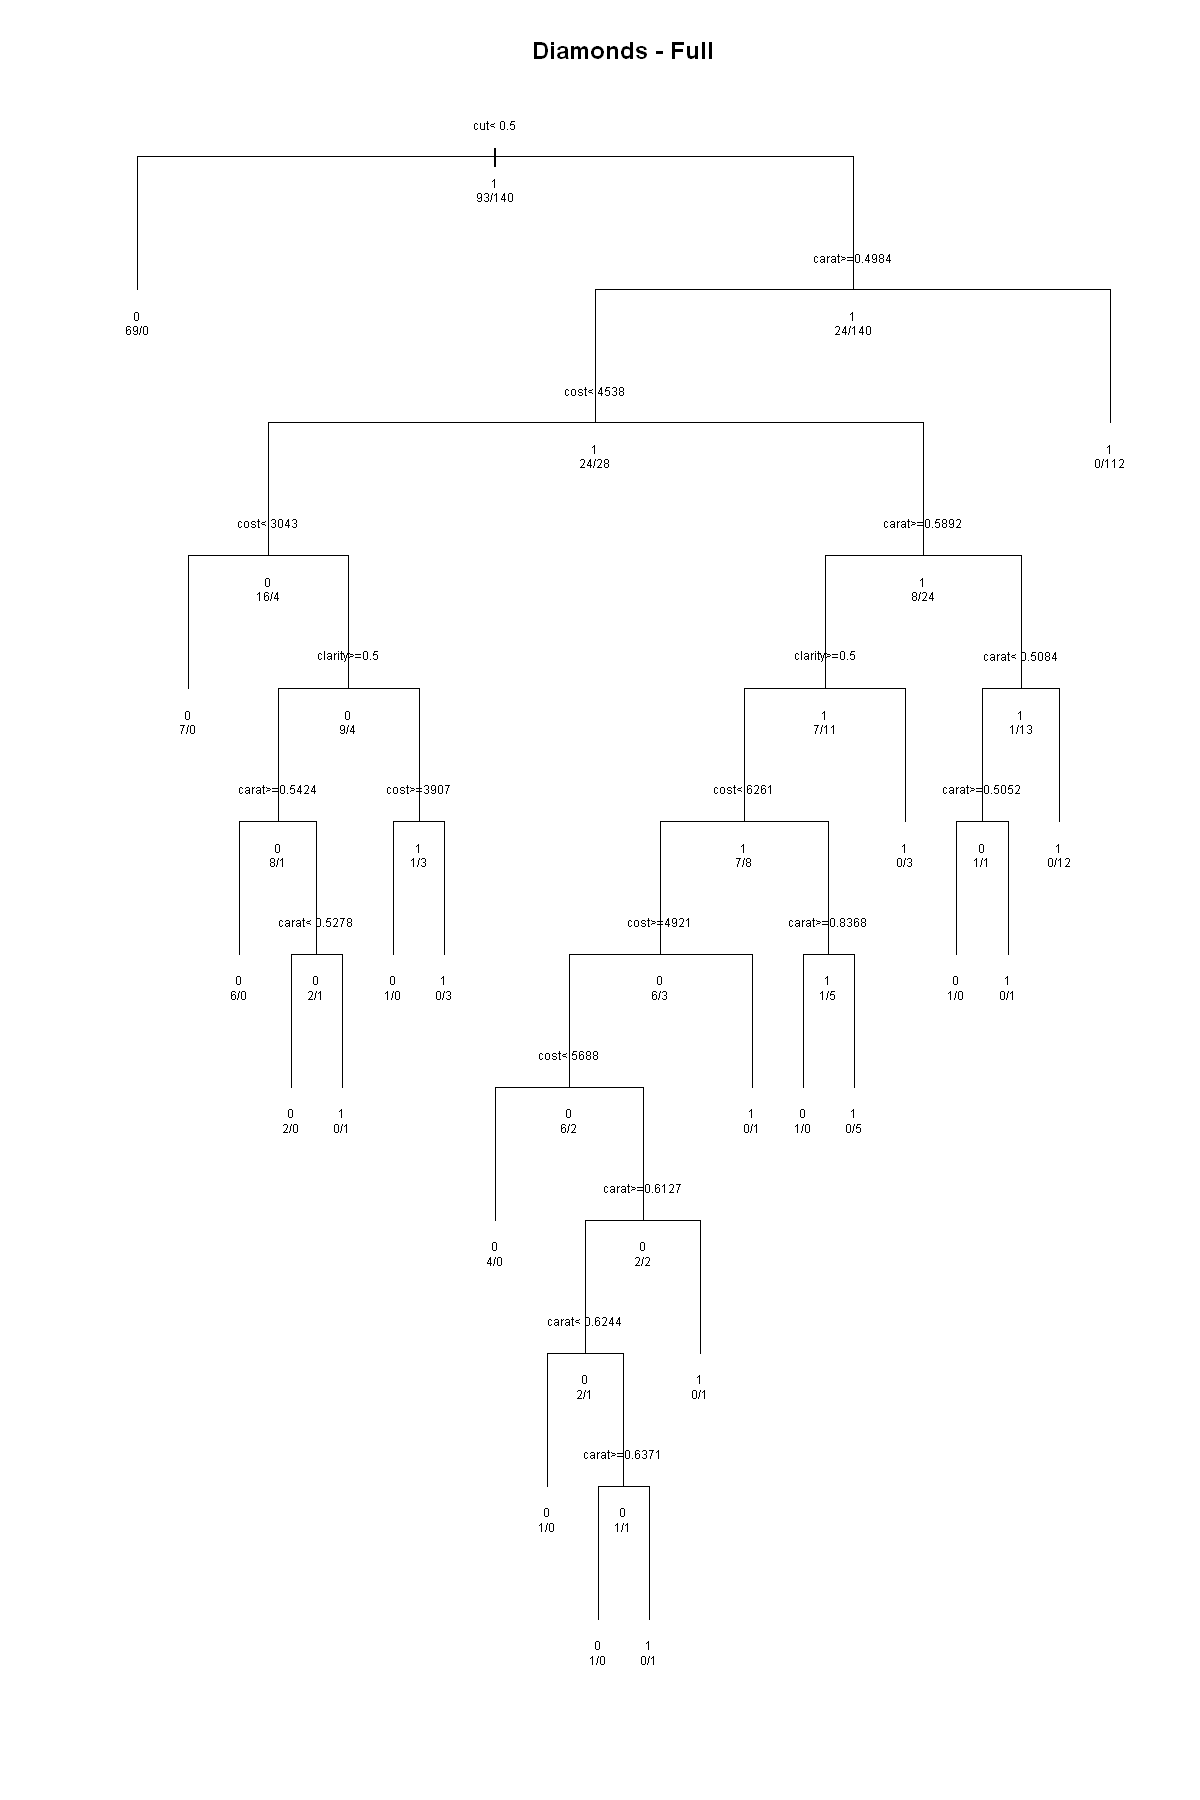

In [59]:
# Plotting options
options(repr.plot.width=10, repr.plot.height=15) # makes size more adequate

# Plot the tree
plot(full_tree, uniform=TRUE, main="Diamonds - Full") # plot tree
text(full_tree, use.n=TRUE, all=TRUE, cex=0.6) # add labels to tree

## Pruned Tree

Create a new tree with the pruning parameter ``cp=0.05`` (leave the ``minsplit`` and ``minbucket`` parameters the same). Display the confusion matrix and calculate its MSE in the test data. 

In [60]:
# Prune the tree to avoid overfitting
# Simple classification pruned tree on training data using all of the variables
pruned_tree <- rpart(as.factor(high_color)~., train, method="class", control=rpart.control(cp=0.05, minsplit=2, minbucket=1))

# Fit model to test data
pred2 <- predict(pruned_tree, test, type="class")
test$pred2 <- ifelse(pred2==1, 1, 0)

# Calculate MSE
mean((test$pred2-test$high_color)^2)

# Display the "confusion" table where we have the predicted values vs. actual values
confusion2 <- table(test$pred2, test$high_color)
confusion2

[1] 0.08974359

   
      0   1
  0  74  10
  1  11 139

Plot the Pruned Tree

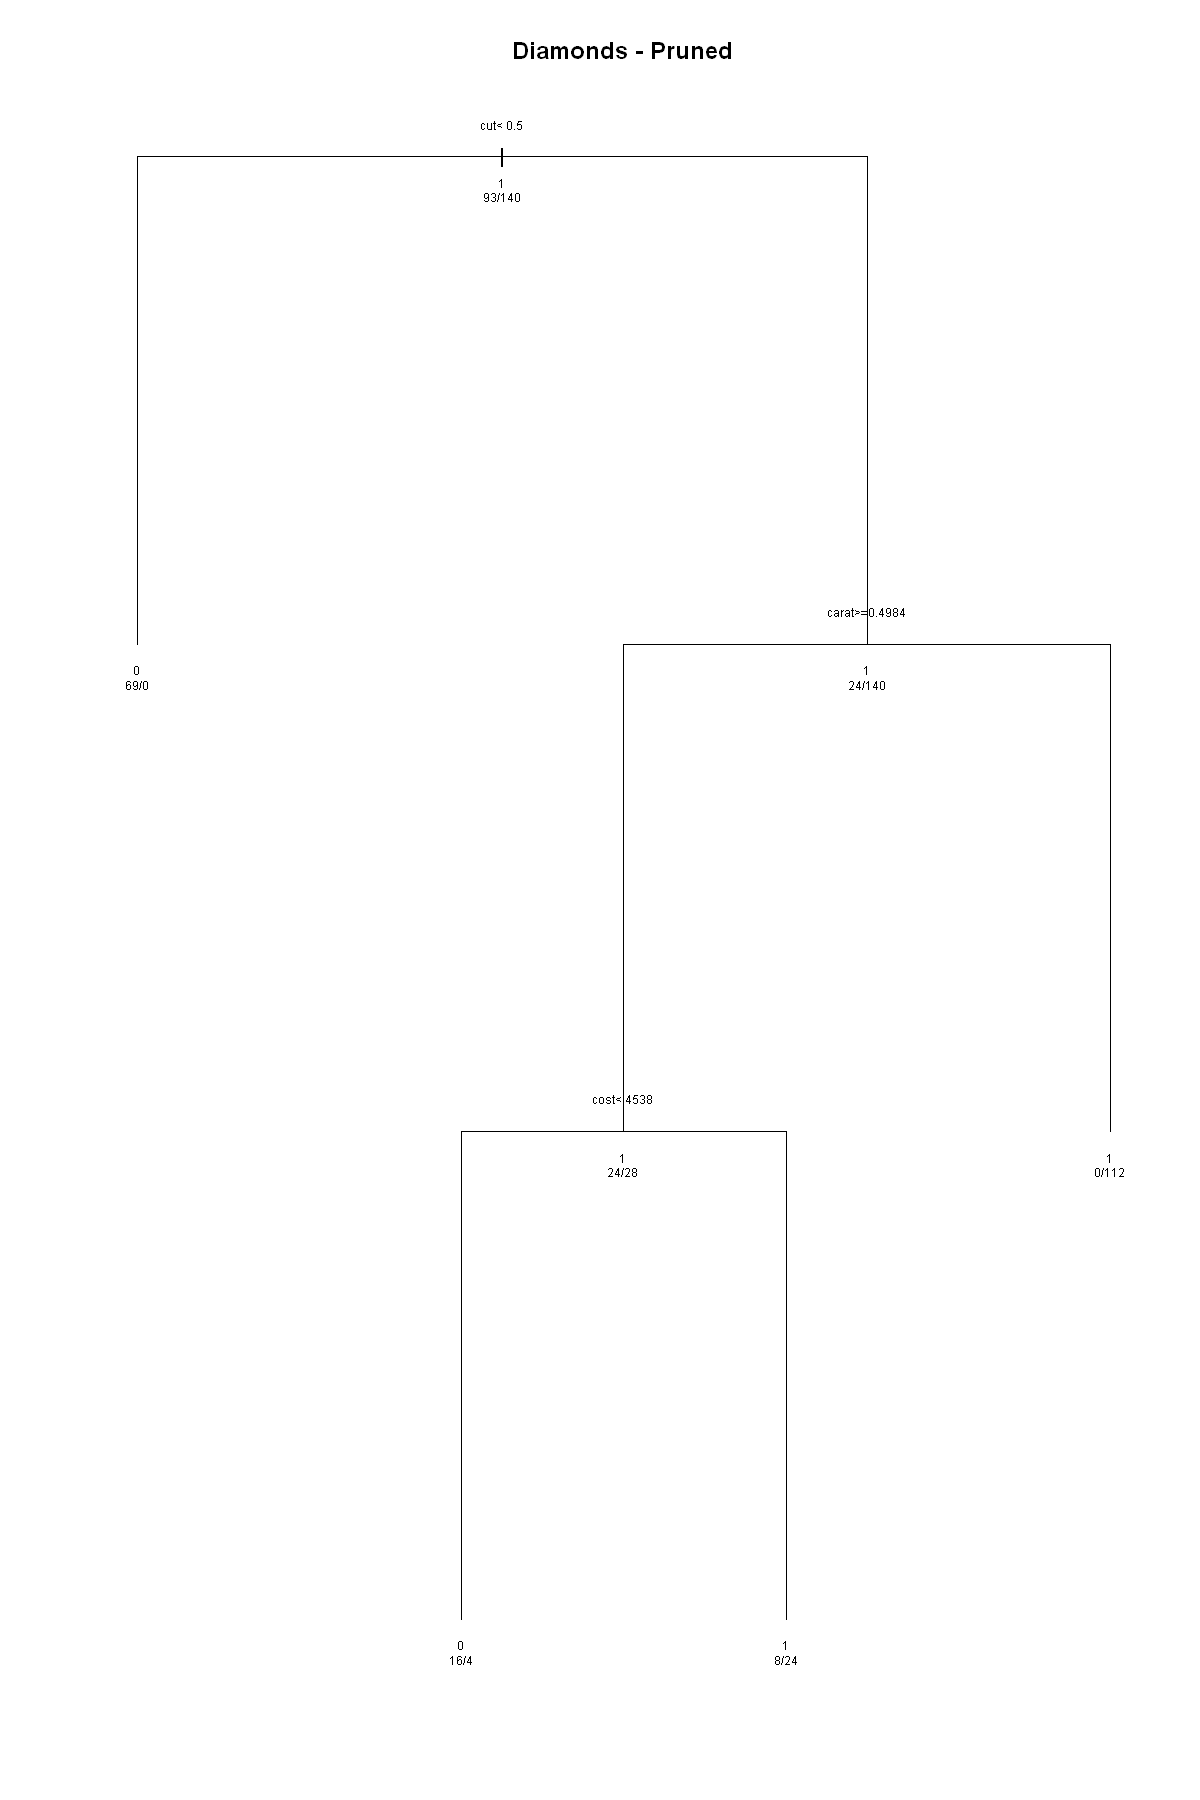

In [61]:
# Plotting options
options(repr.plot.width=10, repr.plot.height=15) # makes size more adequate

# Plot the tree
plot(pruned_tree, uniform=TRUE, main="Diamonds - Pruned") # plot tree
text(pruned_tree, use.n=TRUE, all=TRUE, cex=0.6) # add labels to tree

## Random Forest
Use a random forest model to predict the diamond color.

Run a random forest model on the training data. Seed set to 1 and number of trees set at 500, minimum terminal node size set to 1, and the number of variables sampled at each split set to 2 (``ntree = 500 , nodesize = 1, mtry = 2``). 

In [62]:
# Set seed  for replicating results as there's a lot of randomization that happens in Random Forests
set.seed(1)

# Fit the training data using a Random Forest model
forest <- randomForest(as.factor(high_color)~., data=train, mtry=2, nodesize=1, ntree=500)

# Predict outcomes on the test data
pred_forest <- predict(forest, newdata=test)

# Calculate MSE
test$pred_forest <- ifelse(pred_forest==1, 1, 0)
mean((test$pred_forest-test$high_color)^2)

[1] 0.08119658

Use model to predict test dataset outcomes. Compare predicted and actual outcomes in a confusion matrix.  Calculate the error rate.

In [63]:
# Display confusion matrix
confusion_forest <- table(pred_forest, test$high_color)
confusion_forest

# Calculate MSE
test$pred_forest <- ifelse(pred_forest==1, 1, 0)
mean((test$pred_forest-test$high_color)^2)

           
pred_forest   0   1
          0  74   8
          1  11 141

[1] 0.08119658